# Experiment on a simulated data set with 100 taxa


In what follows, we demonstrate the efficiency of adaptive (multistep) LASSO at recovering sparsity on a fixed phylogenetic tree topology. To reduce parameterization, we use JC model for evolution. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [3]:
import numpy as np
import phyloinfer as pinf
import matplotlib.pyplot as plt
from time import clock
import pandas as pd
import random
%matplotlib inline

In [24]:
%config InlineBackend.figure_format = 'retina'

In [4]:
from model import PHY
from optimizer import fista, adaLasso, raxml
from utils import readTree, detection

In [5]:
# load data
true_tree = readTree('../data/simulation/true_tree_100tips_final.newick', tree_format=3)[0]
pinf.tree.init(true_tree, name='interior')
data, taxa = pinf.data.loadData('../data/simulation/simulated_100tips_final.fasta', data_type='fasta')

In [6]:
true_branch = pinf.branch.get(true_tree)
shrunken_idx = np.where(true_branch==0)[0]

In [34]:
len(true_branch)

197

## Set up the model. 

In [10]:
pden = np.array([0.25, 0.25, 0.25, 0.25])
D, U, U_inv, rate_matrix = pinf.rateM.decompJC()

model = PHY(pden, ('JC',1.0), data)

## Run adaptive LASSO

cycle 1: [niter 120; # zeros: 32.0; step size: 5e-07]
cycle 2: [niter 40; # zeros: 32.0; step size: 5e-07]
cycle 3: [niter 1; # zeros: 32.0; step size: 5e-07]
cycle 4: [niter 1; # zeros: 32.0; step size: 5e-07]

lambda = 0; step size: 5e-07; elasped time: 8.6319 second


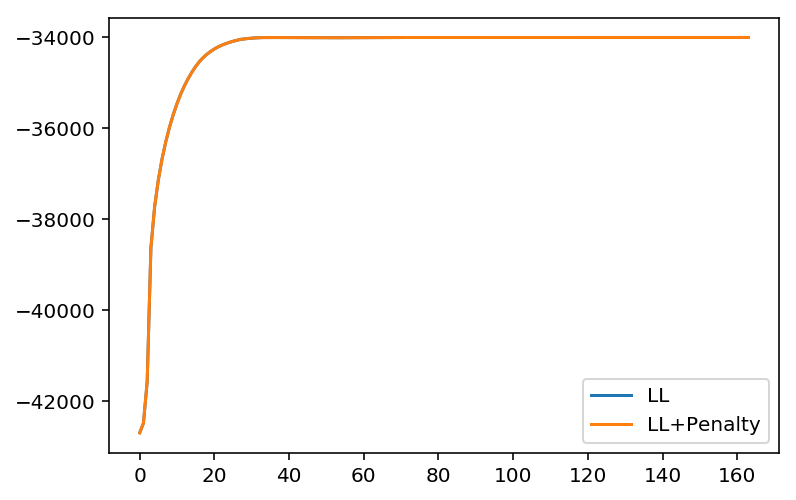

cycle 1: [niter 235; # zeros: 32.0; step size: 5e-07]
cycle 2: [niter 40; # zeros: 38.0; step size: 5e-07]
cycle 3: [niter 35; # zeros: 40.0; step size: 5e-07]
cycle 4: [niter 5; # zeros: 42.0; step size: 5e-07]

lambda = 10; step size: 5e-07; elasped time: 16.9482 second


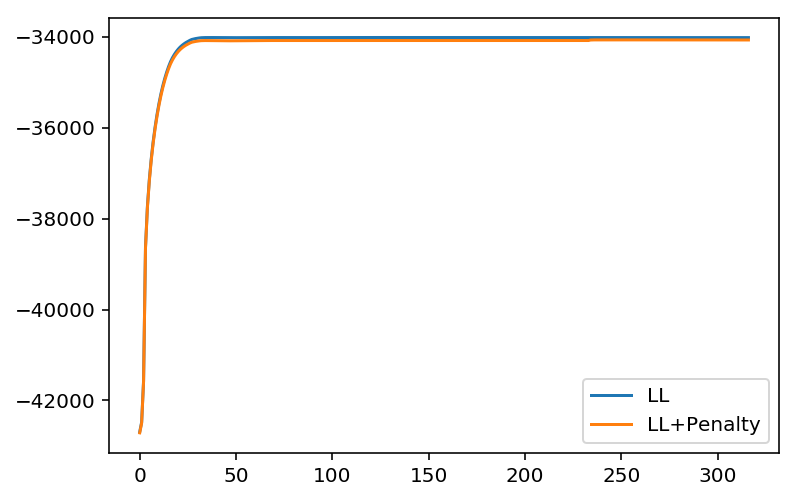

cycle 1: [niter 106; # zeros: 32.0; step size: 5e-07]
cycle 2: [niter 44; # zeros: 40.0; step size: 2.5e-07]
cycle 3: [niter 50; # zeros: 44.0; step size: 2.5e-07]
cycle 4: [niter 64; # zeros: 46.0; step size: 1.25e-07]

lambda = 20; step size: 1.25e-07; elasped time: 14.5913 second


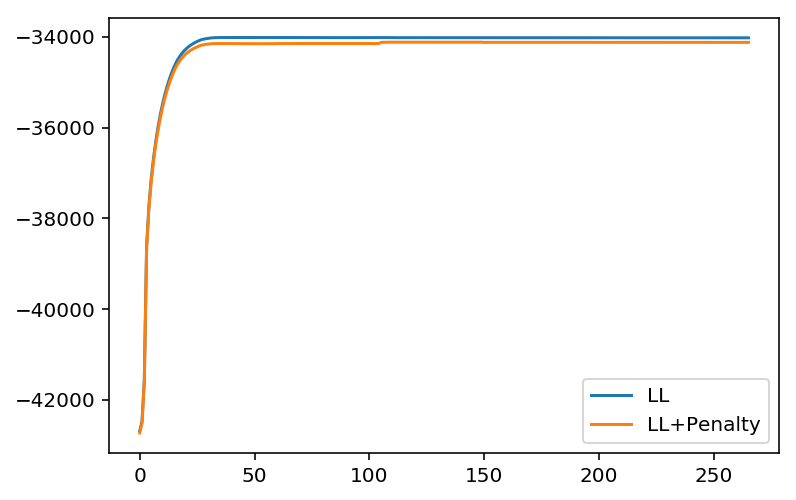

cycle 1: [niter 140; # zeros: 32.0; step size: 5e-07]
cycle 2: [niter 111; # zeros: 41.0; step size: 6.25e-08]
cycle 3: [niter 100; # zeros: 46.0; step size: 6.25e-08]
cycle 4: [niter 89; # zeros: 47.0; step size: 6.25e-08]

lambda = 30; step size: 6.25e-08; elasped time: 23.1871 second


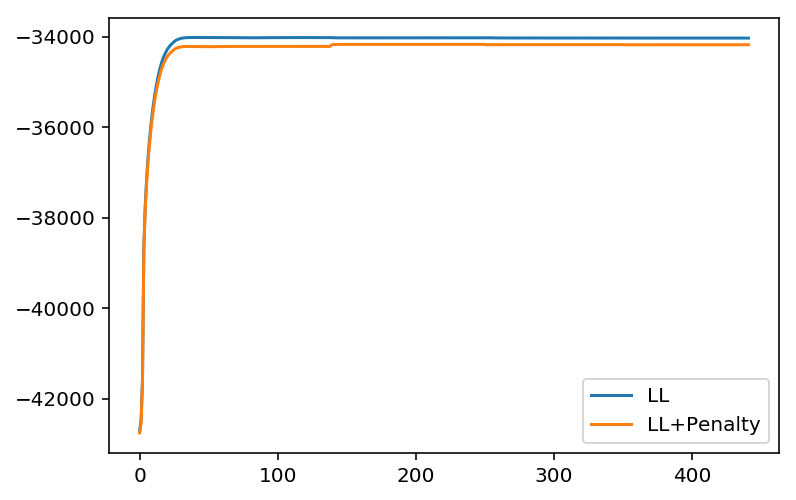

cycle 1: [niter 146; # zeros: 32.0; step size: 5e-07]
cycle 2: [niter 69; # zeros: 42.0; step size: 1.25e-07]
cycle 3: [niter 104; # zeros: 47.0; step size: 6.25e-08]
cycle 4: [niter 148; # zeros: 50.0; step size: 1.5625e-08]

lambda = 40; step size: 1e-06; elasped time: 23.6126 second


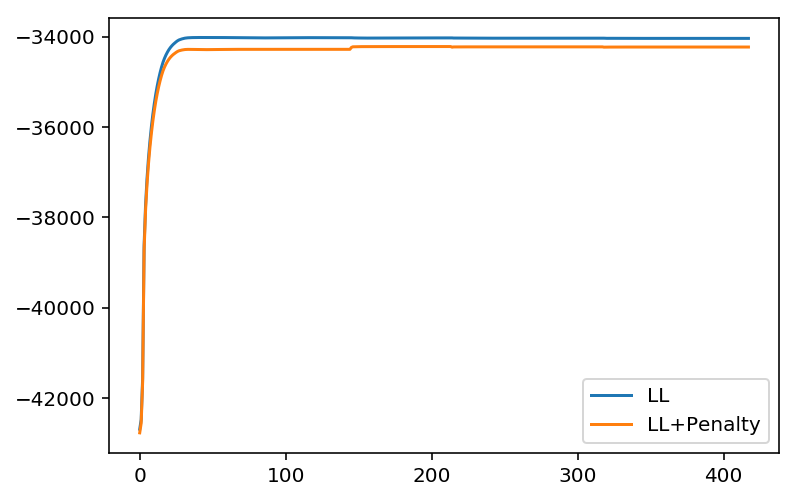

cycle 1: [niter 137; # zeros: 32.0; step size: 5e-07]
cycle 2: [niter 158; # zeros: 43.0; step size: 1.25e-07]
cycle 3: [niter 423; # zeros: 48.0; step size: 1.25e-07]
cycle 4: [niter 153; # zeros: 51.0; step size: 7.8125e-09]

lambda = 50; step size: 1e-06; elasped time: 55.8788 second


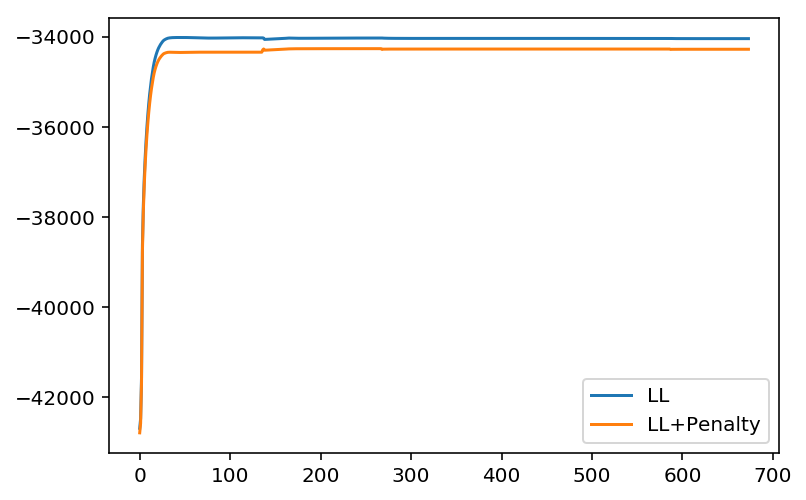

cycle 1: [niter 113; # zeros: 32.0; step size: 5e-07]
cycle 2: [niter 86; # zeros: 44.0; step size: 1.25e-07]
cycle 3: [niter 468; # zeros: 50.0; step size: 3.125e-08]
cycle 4: [niter 132; # zeros: 51.0; step size: 3.90625e-09]

lambda = 60; step size: 1e-06; elasped time: 43.9571 second


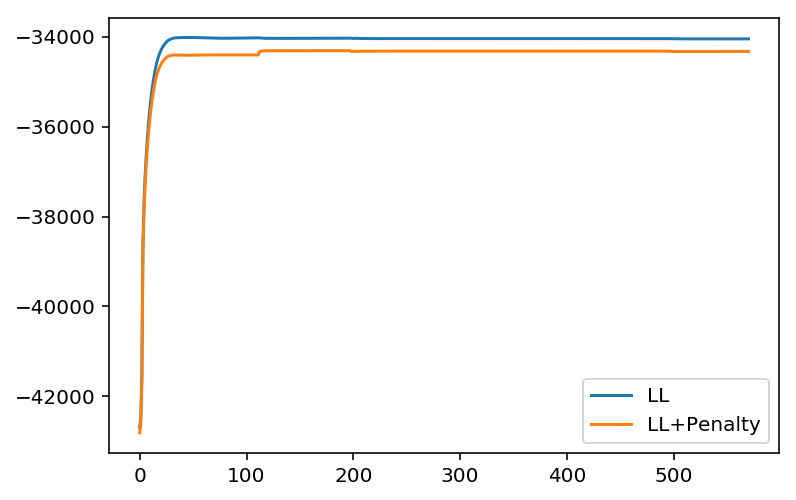

cycle 1: [niter 112; # zeros: 32.0; step size: 5e-07]
cycle 2: [niter 171; # zeros: 44.0; step size: 6.25e-08]
cycle 3: [niter 369; # zeros: 50.0; step size: 1.5625e-08]
cycle 4: [niter 291; # zeros: 52.0; step size: 1.953125e-09]

lambda = 70; step size: 1e-06; elasped time: 65.9942 second


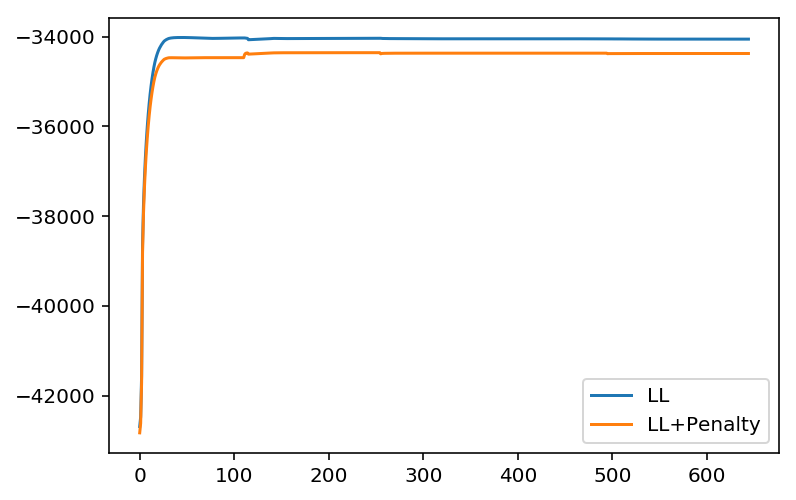

cycle 1: [niter 100; # zeros: 31.0; step size: 5e-07]
cycle 2: [niter 119; # zeros: 45.0; step size: 6.25e-08]
cycle 3: [niter 258; # zeros: 51.0; step size: 7.8125e-09]
cycle 4: [niter 549; # zeros: 52.0; step size: 1.953125e-09]

lambda = 80; step size: 1e-06; elasped time: 66.9144 second


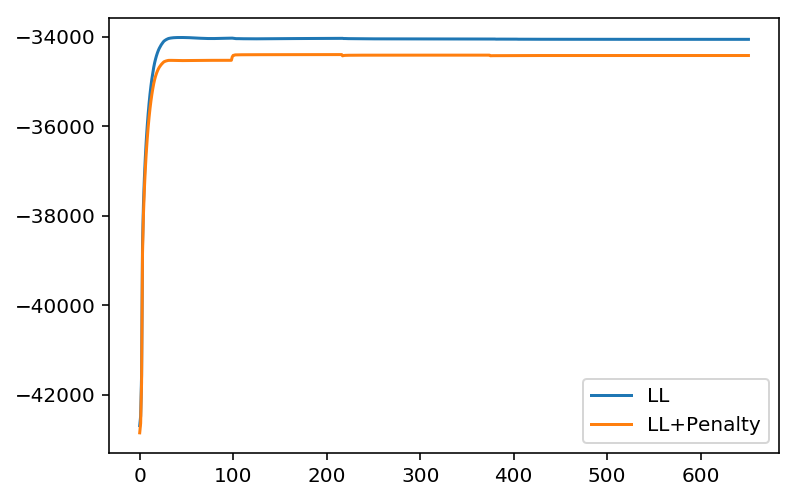

cycle 1: [niter 85; # zeros: 31.0; step size: 1e-06]
cycle 2: [niter 170; # zeros: 45.0; step size: 6.25e-08]
cycle 3: [niter 440; # zeros: 51.0; step size: 7.8125e-09]
cycle 4: [niter 396; # zeros: 53.0; step size: 4.8828125e-10]

lambda = 90; step size: 1e-06; elasped time: 80.5915 second


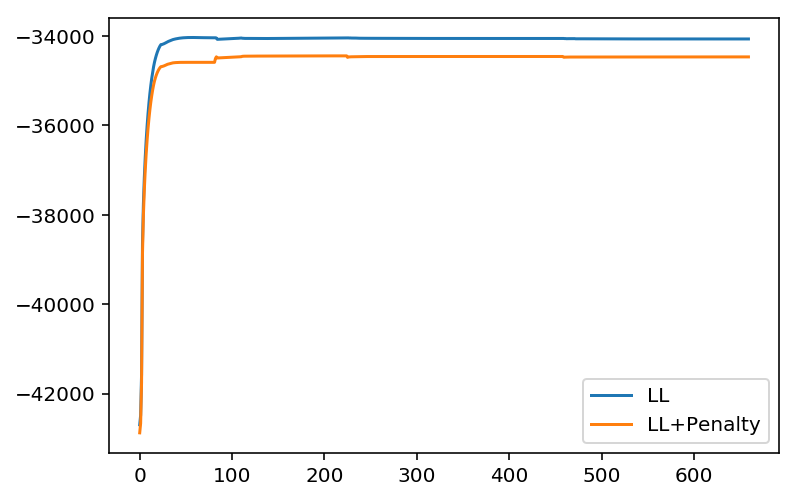

cycle 1: [niter 133; # zeros: 31.0; step size: 1.25e-07]
cycle 2: [niter 161; # zeros: 47.0; step size: 6.25e-08]
cycle 3: [niter 353; # zeros: 51.0; step size: 3.90625e-09]
cycle 4: [niter 718; # zeros: 55.0; step size: 4.8828125e-10]

lambda = 100; step size: 1e-06; elasped time: 98.1038 second


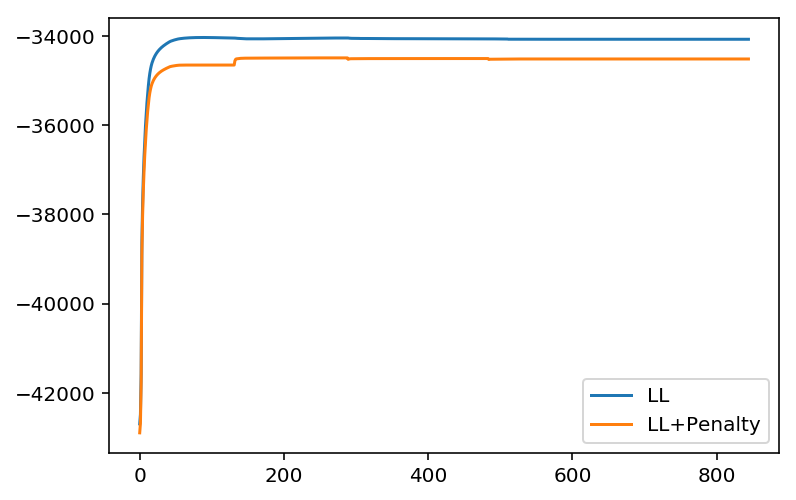

In [27]:
# set up some hyperparameters
lam = 1e-06
beta = 0.5
gamma_ada_penalized = 1.0
wts = np.ones(2*model.ntips-3)

gamma_phy_list = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
brlen_ada_list = []
p_ada_list = []
ada_time_phy_list = []
n_zeros_ada_list = []

# set random starting branch lengths
brlen_init= np.random.exponential(scale=0.01, size=2*model.ntips-3)

for gamma_phy in gamma_phy_list:
    start = clock()
    brlen_ada_lasso, objval_ll_ada_lasso, objval_lasso_ada_lasso, n_zeros_ada_lasso, lam_tuned_ada_lasso = adaLasso(model, true_tree, brlen_init, lam, gamma=gamma_phy, beta=beta, prox='l1', msteps=4, gamma_ada_penalized=gamma_ada_penalized, sparsity_monitor=True)
    
    brlen_ada_list.append(brlen_ada_lasso)
    p_ada_list.append(objval_lasso_ada_lasso[-1])
    ada_time_phy_list.append(clock() - start)
    n_zeros_ada_list.append(n_zeros_ada_lasso)
    
    print "\nlambda = {}; step size: {}; elasped time: {:.04f} second".format(gamma_phy, lam_tuned_ada_lasso, ada_time_phy_list[-1])
    
    plt.plot(objval_ll_ada_lasso, label="LL")
    plt.plot(objval_lasso_ada_lasso, label="LL+Penalty")
    plt.legend(loc=4)
    plt.show()

## Result Analysis

In [28]:
brlen_ada_list_transpose = zip(*brlen_ada_list)

In [35]:
miss_rate = []
false_alarm_rate = []
for j, brlen_ada in enumerate(brlen_ada_list_transpose[-1]):
    miss_zeros, false_alarm = detection(shrunken_idx, brlen_ada)
    miss_rate.append(miss_zeros/50.0)
    false_alarm_rate.append(false_alarm/127.0)
    print "lambda: {}; # miss: {}; # false alarm: {}".format(gamma_phy_list[j], miss_zeros, false_alarm) 

lambda: 0; # miss: 18; # false alarm: 0
lambda: 10; # miss: 9; # false alarm: 1
lambda: 20; # miss: 6; # false alarm: 2
lambda: 30; # miss: 5; # false alarm: 2
lambda: 40; # miss: 2; # false alarm: 2
lambda: 50; # miss: 1; # false alarm: 2
lambda: 60; # miss: 1; # false alarm: 2
lambda: 70; # miss: 1; # false alarm: 3
lambda: 80; # miss: 1; # false alarm: 3
lambda: 90; # miss: 1; # false alarm: 4
lambda: 100; # miss: 1; # false alarm: 6


In [20]:
# miss detection and false alarm for adaLasso and threshold
res = np.empty((5*4,7))
for i, brlen_ada_cycle in enumerate(brlen_ada_list_transpose):
    print "cycle: {}\n".format(i+1)
    for j, brlen_ada in enumerate(brlen_ada_cycle[1:6]):
        miss_zeros, false_alarm = detection(shrunken_idx, brlen_ada)
        res[j+5*i,:4] = [miss_zeros, false_alarm, gamma_phy_list[j+1], i+1]
        print "lambda: {}; # miss: {}; # false alarm: {}".format(gamma_phy_list[j+1], miss_zeros, false_alarm)    
    print ""
    
print '------------------------------------------------'


brlen_orginal = brlen_ada_list[0][-1]
thresholds = sorted([brlen for brlen in brlen_orginal if brlen < 0.01 and brlen > 0.0])
thr_nbin = 6
thresholds_quant = np.percentile(thresholds, q=np.linspace(0,100,thr_nbin))
for j, quant in enumerate(thresholds_quant[1:6]):
    brlen_threshold = np.copy(brlen_orginal)
    brlen_threshold[brlen_threshold<quant] = 0.0
    miss_zeros, false_alarm = detection(shrunken_idx, brlen_threshold)
    for i in range(4):
        res[j+5*i,4:] = [miss_zeros, false_alarm, quant]
    print "threshold: {:.04f}; # miss: {}; # false alarm {}".format(quant, miss_zeros, false_alarm)

cycle: 1

lambda: 10; # miss: 18; # false alarm: 0
lambda: 20; # miss: 18; # false alarm: 0
lambda: 30; # miss: 18; # false alarm: 0
lambda: 40; # miss: 18; # false alarm: 0
lambda: 50; # miss: 18; # false alarm: 0

cycle: 2

lambda: 10; # miss: 12; # false alarm: 0
lambda: 20; # miss: 10; # false alarm: 0
lambda: 30; # miss: 9; # false alarm: 1
lambda: 40; # miss: 9; # false alarm: 1
lambda: 50; # miss: 9; # false alarm: 1

cycle: 3

lambda: 10; # miss: 10; # false alarm: 0
lambda: 20; # miss: 8; # false alarm: 2
lambda: 30; # miss: 6; # false alarm: 2
lambda: 40; # miss: 5; # false alarm: 2
lambda: 50; # miss: 4; # false alarm: 2

cycle: 4

lambda: 10; # miss: 9; # false alarm: 1
lambda: 20; # miss: 6; # false alarm: 2
lambda: 30; # miss: 5; # false alarm: 2
lambda: 40; # miss: 2; # false alarm: 2
lambda: 50; # miss: 1; # false alarm: 2

------------------------------------------------
threshold: 0.0008; # miss: 11; # false alarm 0
threshold: 0.0013; # miss: 9; # false alarm 4
thresh

In [21]:
df = pd.DataFrame(res, columns=['miss_lasso', 'false_lasso', 'lambda', 'cycle', 'miss_detection', 'false_alarm', 'threshold'])

In [22]:
red_color_bar = ['#fdcab5', '#fc8a6a', '#f14432', '#bc141a']
colors = {i+1.0:color for i, color in enumerate(red_color_bar)}
grouped = df.groupby('cycle')

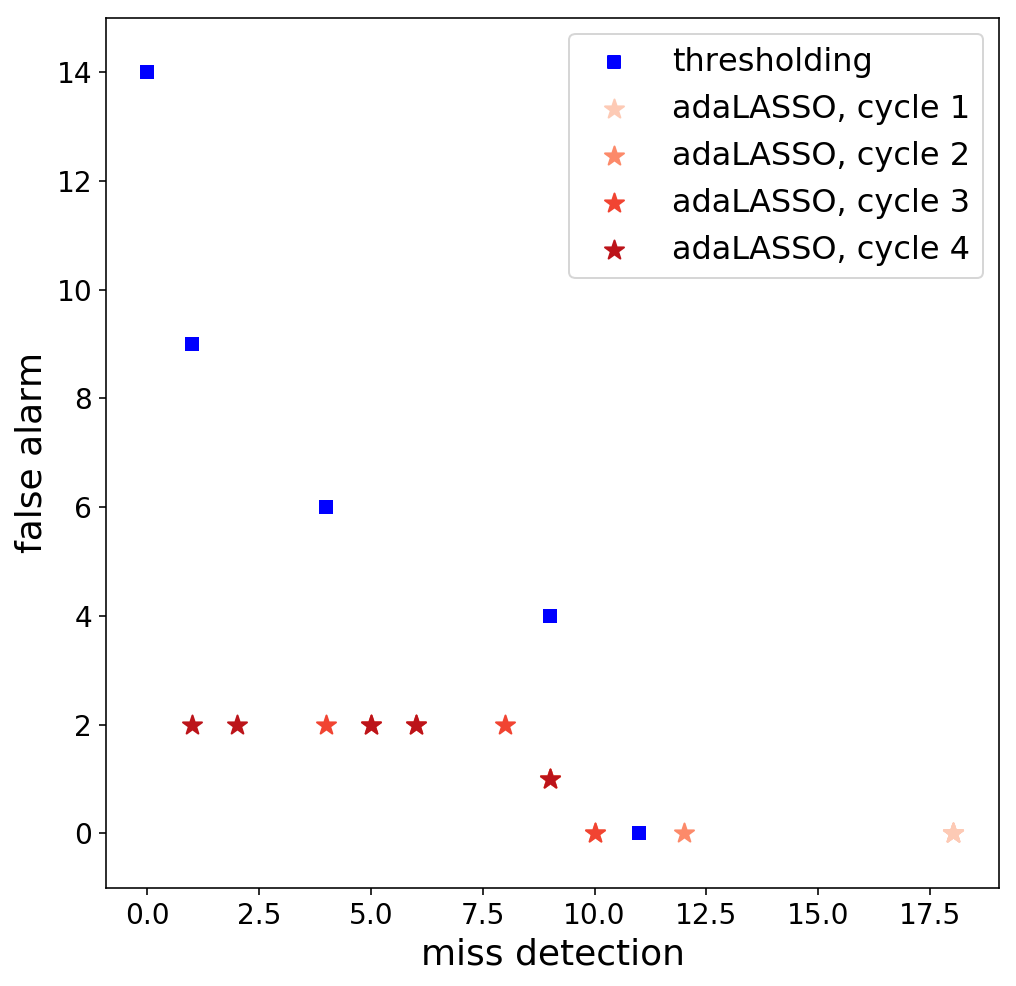

In [25]:
# miss detection vs false alarm

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
df.plot.scatter(x='miss_detection', y='false_alarm', color='blue', marker='s', s=40, label="thresholding", ax=ax)
for name, group in grouped:
    group.plot.scatter(x='miss_lasso', y='false_lasso', color=colors[name], marker='*', s=100, label="adaLASSO, cycle {}".format(int(name)), ax=ax)
ax.legend(loc='best', fontsize=16)
ax.set_xlabel('miss detection', fontsize=18)
ax.set_ylabel('false alarm', fontsize=18)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_ylim(bottom=-1, top=15)

plt.show()

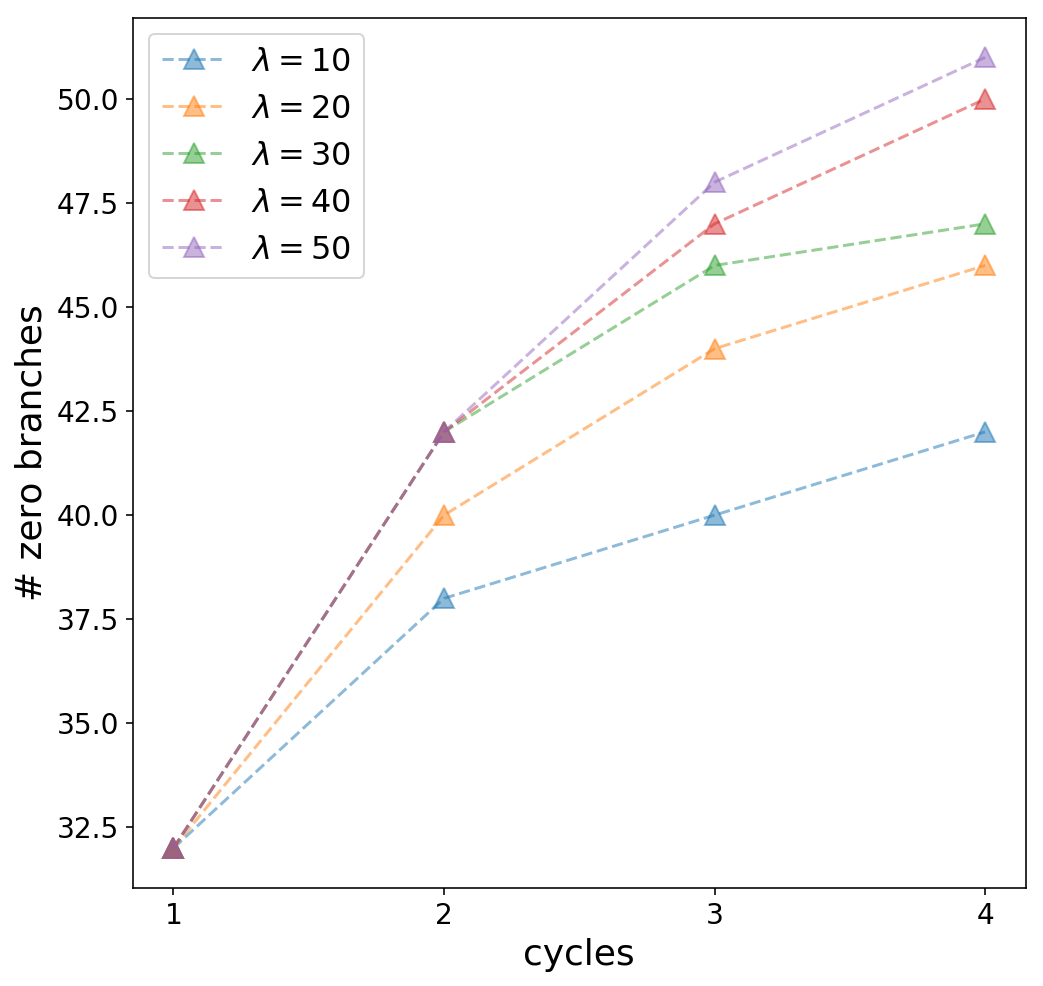

In [26]:
# identified zero branches for multistep adaptive phylogenetic LASSO of different cycles.

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
for i in range(1,6):
    n_zeros_ada = n_zeros_ada_list[i]
    ax.plot(range(1,5), n_zeros_ada, '^--', markersize=10,label=r'$\lambda={}$'.format(gamma_phy_list[i]),alpha=0.5)

ax.set_xlabel('cycles', fontsize=18)
ax.set_ylabel('# zero branches', fontsize=18)
ax.xaxis.set_tick_params(labelsize=14)
ax.xaxis.set_ticks([1,2,3,4])
ax.xaxis.set_ticklabels([1,2,3,4])
ax.yaxis.set_tick_params(labelsize=14)
ax.legend(loc='best', fontsize=16)

plt.show()

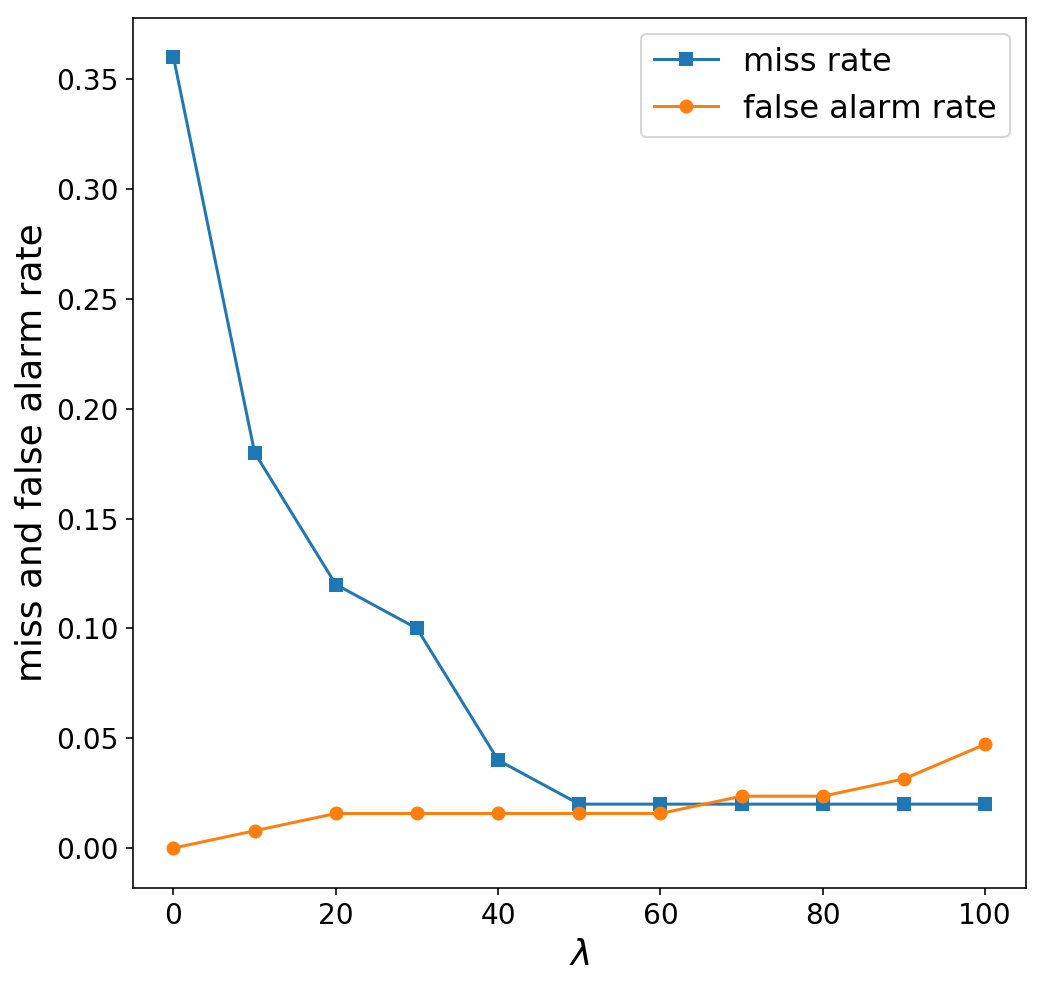

In [48]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

ax.plot(gamma_phy_list, miss_rate, 's-', markersize=6, label='miss rate')
ax.plot(gamma_phy_list, false_alarm_rate, 'o-', markersize=6, label='false alarm rate')

ax.set_xlabel(r'$\lambda$', fontsize=18)
ax.set_ylabel('miss and false alarm rate', fontsize=18)
ax.tick_params(labelsize=14)
ax.legend(loc='best', fontsize=16)

plt.savefig('../figs/simulate_miss_vs_false_alarm_rates.pdf', dpi=1200, bbox_inches='tight')

plt.show()